# Exploratory Data Analysis

Notebook này phân tích khám phá dataset CSE-CIC-IDS2018, mục đích để trả lời những câu hỏi sau:
1. Có bao nhiêu lưu lượng kết nối bình thường / độc hại?
2. Mỗi loại tấn công có bao nhiêu lưu lượng kết nối?
3. Có mối tương quan nào giữa các trường dữ liệu trong bản ghi?
4. Những trường dữ liệu nào có liên quan đến sự phân loại (Lưu lượng mạng độc hại/ an toàn)


Ở đây em chỉ phân tích phần đầu tiên, Tiền xử lý dữ liệu

## Tiền xử lý dữ liệu


Tiền xử lý là quá trình xử lý dữ liệu thô nhằm cải thiện chất lượng dữ liệu, mục đích chính là cải thiện chất lượng của kết quả khai phá dữ liệu


### Tóm tắt các bước thực hiện:




1.   Đọc các dữ liệu lưu lượng từ datasheet
2.   Xử lý các giá trị khác thường ( thiếu / giá trị vô cực...)
3.   Gán nhãn cho từng loại lưu lượng ( An toàn / độc hại) và các kiểu tấn công ( đối với lưu lượng độc hại)



### Các bước thực hiện


Đầu tiên, import các thư viện sau trong Python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats
from scipy.stats import ks_2samp

%matplotlib inline

#### Bước 1: Đọc dữ liệu

Tiếp theo, import thư mục chứa file CSV

In [3]:
# set base path to the directory containing the csv files of the dataset
dataset_base_path = r'/path/to/dataset'

Khai báo tên và kiểu dữ liệu cho các trường dữ liệu trong mỗi bản ghi ;

In [4]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

In [ ]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = pd.concat((pd.read_csv(f, dtype=types) for f in csv_files))

#### Bước 2: Xử lý giá trị thiếu

Dataset có những trường dữ liệu có giá trị vô cực hoặc thiếu giá trị như Infinity hoặc NaN. Ta cần phải tìm những cột có trường dữ liệu này và xử lý chúng

Liệt kê các cột có dữ liệu Infinity. Mặc dù Infinity không phải là *thiếu dữ liệu* , nhưng không thể sử dụng hiệu quả nên cũng được coi như là thiếu.
Ta tìm những cột có Infinity bằng lệnh sau

In [ ]:
inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]

print(f'Columns containing infinity values {inf_columns}')

Hai cột chứa giá trị inf là `flow_byts_s` và `flow_pkts_s`.  
Ta sẽ thay thế các trường dữ liệu `inf` thành `NaN` , sau đó điền vào các trường NaN bằng trung vị

In [ ]:
for col in inf_columns:
    #thay thế inf thành NaN
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    #tính trung vị 
    mean = df[col].mean()
    #thay thế NaN thành trung vị
    df[col].fillna(mean, inplace=True)

#### Bước 3: Tạo nhãn

Để phân tích dataset, tác giả đã thêm vào 2 nhãn sau:

1. `label_is_attack` Chỉ ra lưu lượng dữ liệu đó là bình thường hay là độc hại
2. `label_is_attack_[attack_type]` Nếu là lưu lượng dữ liệu độc hại, chỉ ra thể loại của nó

In [ ]:
df['label'] = df.label.astype('category')
df['label_code'] = df['label'].cat.codes
df['label_is_attack'] = df.label.apply(lambda x: 0 if x == 'Benign' else 1)

In [ ]:
attack_types = [a for a in df.label.value_counts().index.tolist() if a != 'Benign']

for a in attack_types:
    l = 'label_is_attack_' + a.replace('-', ' ').replace(' ', '_').lower()
    df[l] = df.label.apply(lambda x: 1 if x == a else 0)

#### Tổng quát về dataset

Về tổng quan, có toàn bộ *16232943* dữ liệu lưu mạng không rỗng

In [ ]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 1048574
Data columns (total 96 columns):
dst_port                                    16232943 non-null uint32
protocol                                    16232943 non-null uint8
timestamp                                   16232943 non-null object
flow_duration                               16232943 non-null int64
tot_fwd_pkts                                16232943 non-null uint32
tot_bwd_pkts                                16232943 non-null uint32
totlen_fwd_pkts                             16232943 non-null uint32
totlen_bwd_pkts                             16232943 non-null uint32
fwd_pkt_len_max                             16232943 non-null uint16
fwd_pkt_len_min                             16232943 non-null uint16
fwd_pkt_len_mean                            16232943 non-null float32
fwd_pkt_len_std                             16232943 non-null float32
bwd_pkt_len_max                             16232943 non-n

## reproduce

Em đã thử reproduce các bước, nhưng vẫn gặp những khó khăn (chủ quan/ khách quan), chủ yếu là do vấn đề sau:


### Không include link dataset đi kèm 

Hướng giải quyết:  Tự tải dataset theo trên website: 
1. Download AWS CLI
2. Chạy lệnh:


```
aws s3 sync --no-sign-request --region <vùng máy chủ AWS gần nhất> "s3://cse-cic-ids2018/" <nơi lưu dataset>
```

Hậu quả : theo nhận xét chủ quan của em , file csv tải được **khá khác biệt** so với file tác giả đã dùng, và khó khăn này dẫn đến một vài khó khăn phía dưới

#### Dataset quá nặng (~452GB )


Khi list các file của dataset: 


```
aws s3 ls --no-sign-request "s3://cse-cic-ids2018" --recursive --human-readable --summarize
```
thì tổng dung lượng quá nặng



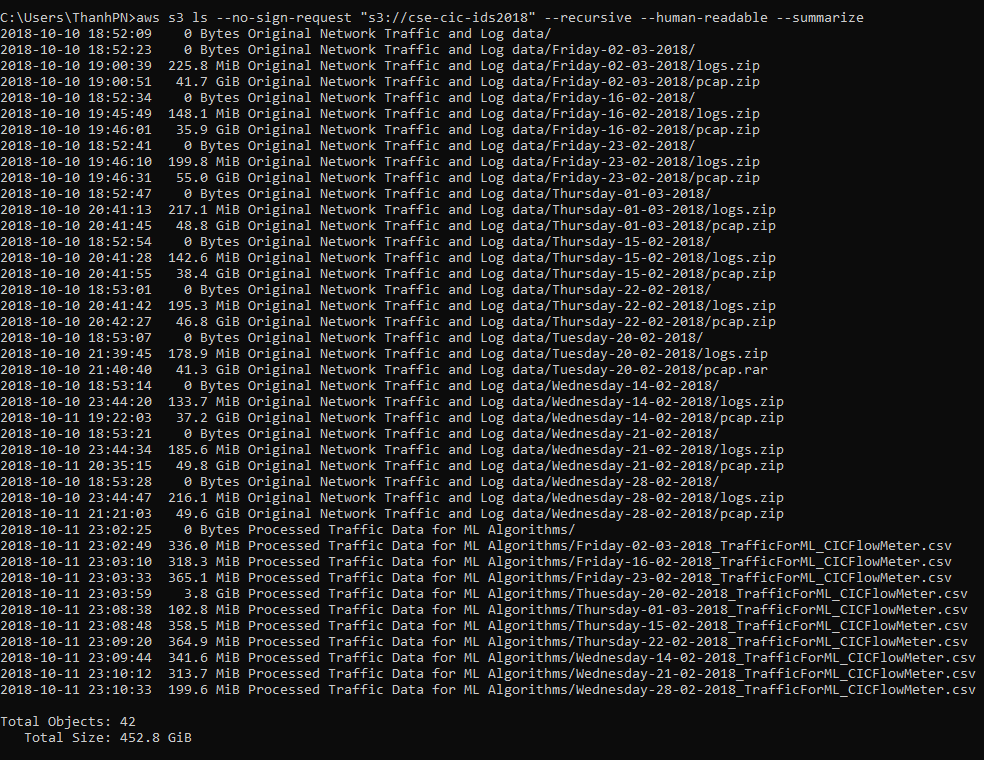


Hướng khắc phục: Tải riêng các file CSV theo lệnh sau:


```
aws s3 cp --no-sign-request "s3://cse-cic-ids2018/<tên file>" "<nơi lưu>"
```




#### File csv tải về có nhiều dòng header 

Hậu quả: sẽ bị lỗi như sau khi xử lý `inf` và `NaN`


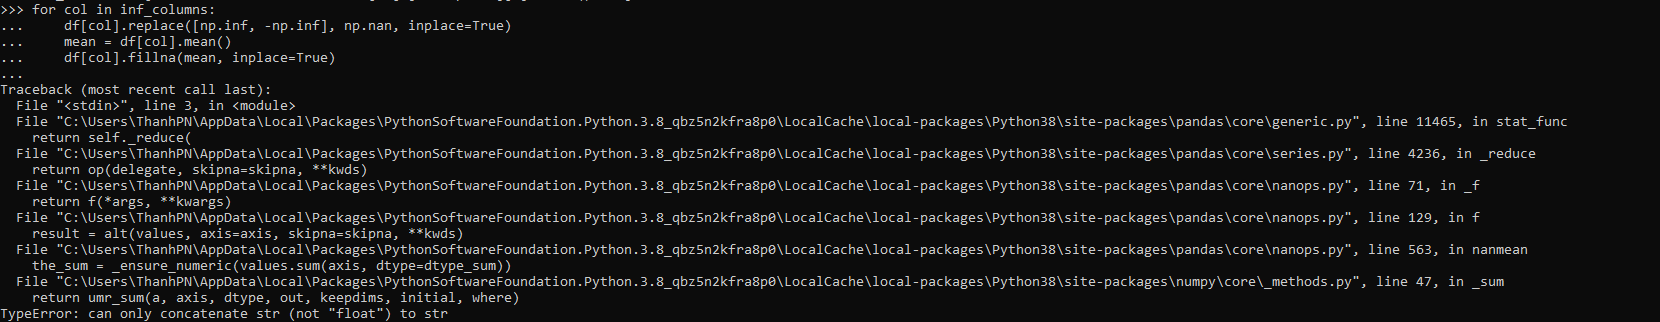

Hướng xử lý:  Có thể mở file trong Excel, bật filter "label" ở cột Label để thấy tất cả dòng Header. Sau đó xóa tất cả dòng Header dư


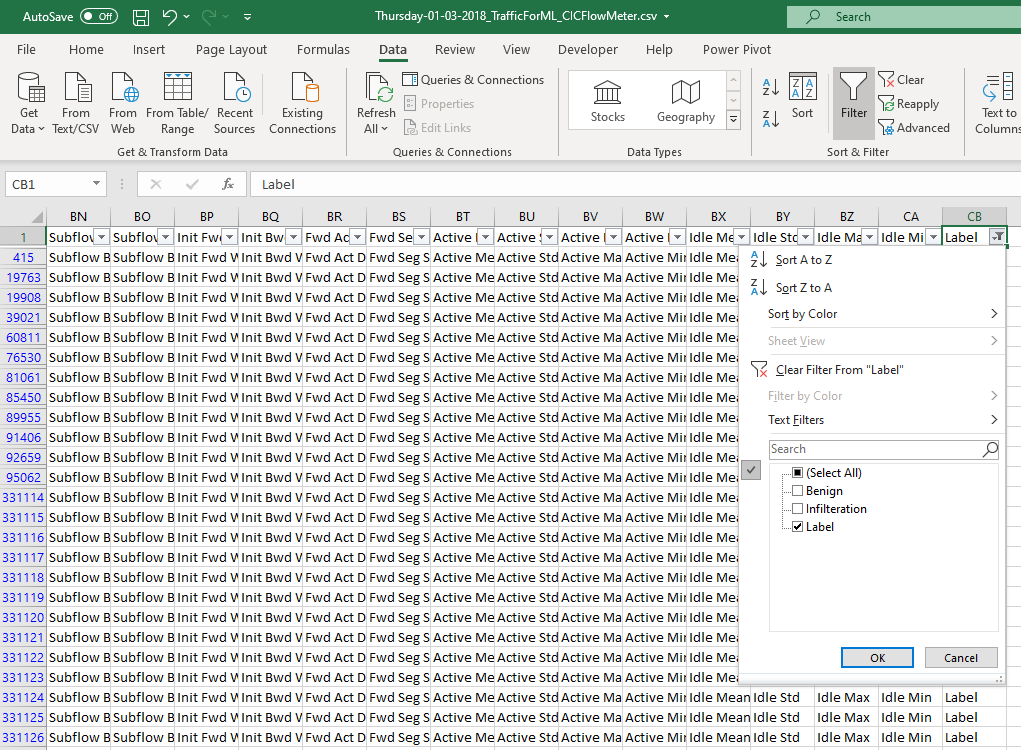

#### Lỗi khi tạo nhãn

Lí do: Các dòng header của file csv **khác** so với khai báo trong python




##### Phương án giải quyết 1:

Rename thủ công tất cả cột trong dataframe ( sau khi xong bước 2)



```
df.rename(columns={'<tên cũ>': '<tên mới>'}, inplace=True)
```



image.png

##### Phương án giải quyết 2:

Đổi tên các cột trước khi import vào Python


Phát sinh vấn đề: Bị lỗi ( dự đoán là do có `inf` và `NaN`) 

-> không áp dụng được

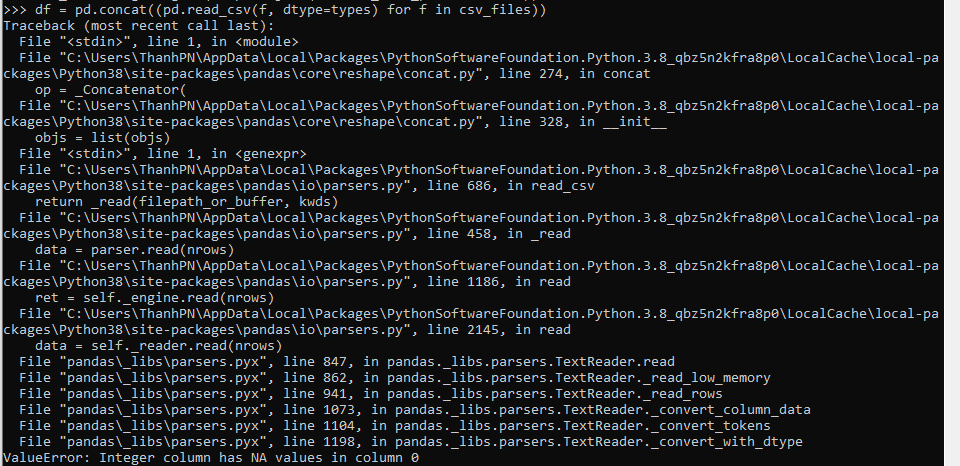

#### Data sau khi xử lý vẫn còn trường thông tin NULL


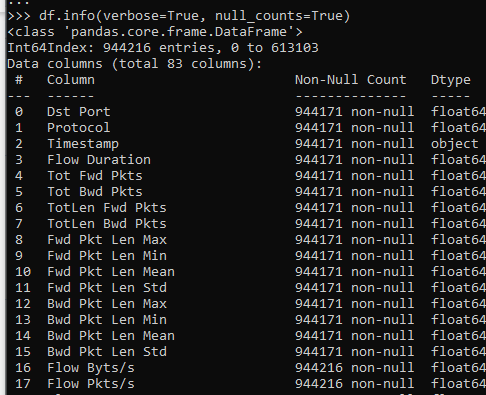

**Chưa có phương án giải quyết**